In [130]:
import os
os.getcwd()
import sys
sys.path.append('/Users/juncheng/PycharmProjects/test')
import matplotlib.pyplot as mpl
import numpy as np
import modelBuilder
import models
import time
import jax

In [131]:
# Initialize the model and compile it for JAX
def InitialiseModel(ParamArray,runTime,totalRuns,t0 = time.time()):
    # initialiseModel(lung,heart,gasExchange,nrLevels)
    # lung,heart,gasExchange  --> True or False to enable the parts of the model
    # nrLevels                --> 1 (Basic Model) or 2 or 5 (trees with 2 or 5 generations)
    model = modelBuilder.ModelStructure(True,False ,False,1,ParamArray)


    # Get the maps of the equations and the parameters of the model for the solver
    states, capacitorObjects, resistorObjects, connectionbjects, dVdt, capacitors, flows, resistors, pressures = model.getEquationMaps()

    # Create the model object with the parameters and the equations to be solved by JAX
    cpModel = models.CardioPulmonaryModel(capacitorObjects, resistorObjects, connectionbjects, states)

    t1 = time.time()
    print(str(np.round(t1 - t0, 4)) + ' -> Model Initialised!')
    
    # First run to compile the model
    res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,states)
    print(str(np.round(time.time() - t1, 4)) + ' -> Compiled!')
    t1 = time.time()

    

    newStates = {key: float(y_dense[key][-1]) for key in states.keys()}
    res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,newStates)
    pressureRes = {key: np.array(value) for key, value in out.items()}
    results = {
        #'I_Lu|0': pressureRes['I_Lu|0'],
        #'I_Lu|0|0': pressureRes['I_Lu|0|0'], 
        'I_Lu|0|0|0': pressureRes['I_Lu|0|0|0']
        }

    

    return cpModel, newStates, results, t1

In [132]:
def RunModel(cpModel, states ,ParamArray,runTime,totalRuns,t1 = time.time()):
    # initialiseModel(lung,heart,gasExchange,nrLevels)
    # lung,heart,gasExchange  --> True or False to enable the parts of the model
    # nrLevels                --> 1 (Basic Model) or 2 or 5 (trees with 2 or 5 generations)
    # ParamArray              --> Array with the parameters of the model
    t1 = time.time()
    with jax.default_device(jax.devices("cpu")[0]):
        jax.config.update("jax_enable_x64", True)

        states['R_Lu|0'] = ParamArray[0]
        states['R_Lu|0|0'] = ParamArray[1]
        states['R_Lu|0|0|0'] = ParamArray[2]
        states['C_Lu|0'] = ParamArray[3]
        states['C_Lu|0|0'] = ParamArray[4]
        states['C_Lu|0|0|0'] = ParamArray[5]

        for nruns in range(totalRuns):

            # Run the model with the updated states
            res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,states)

            # Concatenate the results of the runs to the previous results
            pressureRes = {key:  np.array(value) for key, value in out.items()}  
            runsRes = {key: np.array(value) for key, value in y_dense.items()} 
            
            #print(str(np.round(time.time() - t1, 4)) + ' -> Run:' + str(nruns) + ' of ' + str(totalRuns-1) + ' completed!')


        return pressureRes['I_Lu|0|0|0']

In [133]:
runTime = 3.0
totalRuns = 1
totalTime = runTime*totalRuns

# Create the time vector
t = np.arange(0, totalTime + totalRuns*0.01 , 0.01)


# Here is where you define the values for the parameters
#ParamArray = ['R_Lu|0','R_Lu|0|0', 'R_Lu|0|0|0', 'C_Lu|0', 'C_Lu|0|0', 'C_Lu|0|0|0']
ParamArray = [0.001,0.002,0.003,2.4,3,100]
# with initial conditions -> [0.001,0.002,0.003,2.4,3,100,28,36,1400]

with jax.default_device(jax.devices("cpu")[0]):
    jax.config.update("jax_enable_x64", True)
    # This function takes those parameters and runs the model
    model,states,runRes, t1 = InitialiseModel(ParamArray,runTime,totalRuns,t0 = time.time())
    # runRes is a dictionary with keys(['I_Lu|0', 'I_Lu|0|0', 'I_Lu|0|0|0'])
    # The time series is the alue of the key

print(runRes.keys())

Simple Lung initialised
0.0025 -> Model Initialised!
0.0582 -> Compiled!
dict_keys(['I_Lu|0|0|0'])


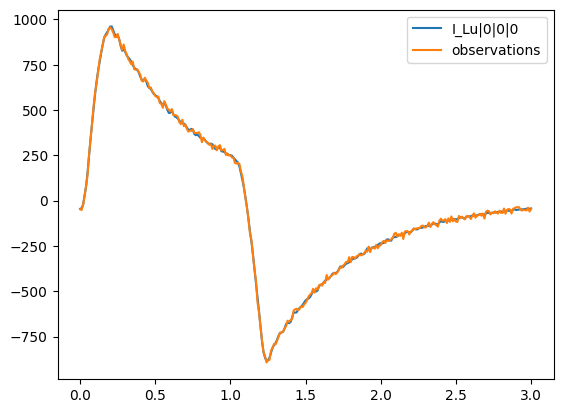

In [134]:
# Print results of the simulation and plot them
# Observation is the results of the simulation with noise added
for key,results in runRes.items():
    obs = np.array(results)+ np.random.normal(0,10,results.shape)
    mpl.plot(np.array(t),np.array(results), label = key)
    mpl.plot(np.array(t),np.array(obs), label = 'observations')
    mpl.legend()
    mpl.show()


In [135]:
import functools as ft
import math as math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy
#import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [136]:
# Function to run the model given an input parameter array
def lung(model,states,x,t1):
    runTime = 3.0
    totalRuns = 1
    ParamArray =[math.exp(x[0])/500,math.exp(x[1])/500,math.exp(x[2])/500,math.exp(x[3]),math.exp(x[4]),math.exp(x[5])*50]
    #[math.exp(x[0])/500,0.002,math.exp(x[1])/500,2.4,3,100]
    runRes = RunModel(model,states,ParamArray,runTime,totalRuns,t1)
    return(runRes)

In [137]:
## Implausibility measure
md=1 # model discrepancy
me=1 # measurement error
def Imp(obs,x,md,me):
    m = np.array(lung(model,states,x,t1))
    I = math.sqrt(sum((np.array(obs)-np.array(m))**2)/((me+md)*obs.shape[0]))
    return(I)

Implausibility measure:
0.0566 -> Run:0 of 0 completed!
7.086629509651336
Implausibility measure: one of random samples:
0.0908 -> Run:0 of 0 completed!
698.3042385197471
Implausibility measure: mean of random samples:


0.0547 -> Run:0 of 0 completed!
445.4494490307237
0.0673 -> Run:0 of 0 completed!
0.0512 -> Run:0 of 0 completed!


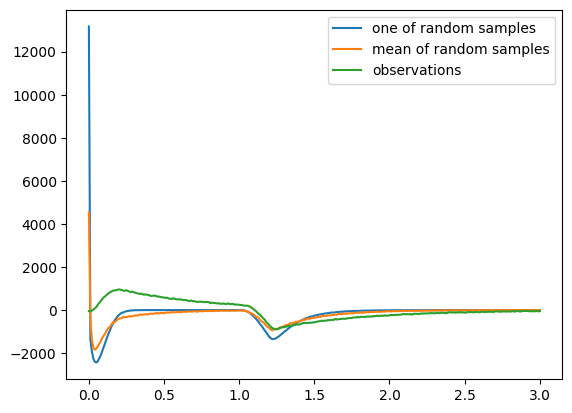

In [138]:
print('Implausibility measure:')
print(Imp(obs,[math.log(0.001*500),math.log(0.002*500),math.log(0.003*500),math.log(2.4),math.log(3),math.log(100/50)],md,me))

samples = np.random.randn(500,6)
#result = np.concatenate((np.exp(np.random.randn(500,3))/500,np.exp(np.random.randn(500,2)),np.exp(np.random.randn(500,1))*50),axis=1)
values = samples[0,:]
mean = np.mean(samples,0)

print('Implausibility measure: one of random samples:')
print(Imp(obs,values,md,me))
print('Implausibility measure: mean of random samples:')
print(Imp(obs,mean,md,me))
mpl.plot(np.array(t),np.array(lung(model,states,values,t1)), label = 'one of random samples')
mpl.plot(np.array(t),np.array(lung(model,states,mean,t1)), label = 'mean of random samples')
mpl.plot(np.array(t),np.array(obs), label = 'observations')
mpl.legend()
mpl.show()

In [139]:
#Subset Simulation for history matching
#algorithm we use to update samples, and we here consider Modified Metropolis
###modified metropolis
def modmetro(nc,ns,d,z,q,Y):
    for j in range(1,nc+1):
        for m in range(1,ns+1):
            ### step 1
            for k in range(1,d+1):
                a = z[j-1,k-1,m-1]+np.random.randn(1)
                r = min(1, norm.pdf(a)/norm.pdf(z[j-1,k-1,m-1]))
                if np.random.rand(1)<r:
                    q[k-1]=a
                else:
                    q[k-1]=z[j-1,k-1,m-1]
            ###step 2 q belongs to F_L or not
            if Imp(obs=obs,x=q,me=me,md=md)<Y: ###responses
                z[j-1,:,m]=q
            else:
                z[j-1,:,m]=z[j-1,:,m-1]
    return(z)

def sus(obs,n,me,md):
    d = 6 #dimension of the input space first layer concludes 2 parameters?
    YF = 10 #critical threshold (gx>=YF)
    n = n #3000 #number of samples per level
    p = 0.1 #level probability
    nc = int(n*p) #number of Markov chains
    ns = int((1-p)/p) #number of states in each chain
    L = 0 # zero level
    Lmax = 100 # define the possible maximum of number of levels
    Xs = np.zeros((n,d,Lmax)) #samples for different levels
    xs = np.random.randn(n,d) # Monte Carlo samples(initial space filling samples)
    Xs[:,:,0] = xs ### samples for zero level
    nF = np.zeros(Lmax) # number of failure samples
    ys = np.zeros((Lmax,n)) # responses
    zs = np.zeros((nc,d,ns+1)) # seeds
    Ys = np.zeros(Lmax)# intermediate threshold
    qs = np.zeros(d)## potential next state in Markov chain?
    index = [0]
    for i in range(1, n+1):
        ys[0,i-1] = Imp(obs=obs,x=Xs[i-1,:,L],me=me,md=md) 
        if ys[0,i-1]<YF: # whether it falls in failure domain
            nF[0]=nF[0]+1
            index.append(i-1)       
    while (nF[L]/n)<p and (L<11): # stopping criterion
        index = [0]
        L=L+1 # next conditional level is needed
        w = ys[L-1,:]
        ind = sorted(range(len(w)), key=lambda k: w[k])# original index of descending responses
        ys[L-1,:] = ys[L-1,ind] #renumbered responses
        Xs[:,:, L-1] = Xs[ind,:,L-1] # renumbered samples
        Ys[L-1] = (ys[L-1,nc-1]+ys[L-1,nc])/2 #L^th intermediate threshold
        zs[:,:,0] = Xs[range(0,nc),:, L-1] # seeds of Markov chain
        print('L = ', L)
        print('intermediate threshold:',Ys[L-1])
        zs = modmetro(nc,ns,d,z=zs,q=qs,Y=Ys[L-1])###modified metropolis algorithm
        for j in range(1,nc+1):
            for m in range(1,ns+2):
                Xs[(j-1)*(ns+1)+m-1,:,L]=zs[j-1,:,m-1]### update L-th level samples
        zs = np.zeros((nc,d,ns+1))
        for i in range(1,n+1):
            ys[L, i-1] = Imp(obs=obs,x=Xs[i-1,:,L],me=me,md=md)
            if ys[L, i-1]<YF:
                nF[L]=nF[L]+1
                index.append(i-1)
    return(Xs[:,:,L])
    #Xfin = Xs[index[1:],:,L]
    #return(Xfin)



In [140]:
# history matching
start_time = time.time()
N=20
X=sus(obs=obs,n=N,me=me,md=md)#new particles obtained from SuS
y = np.zeros(X.shape[0])
for i in range(1,X.shape[0]+1):
    y[i-1] = Imp(obs=obs,x=X[i-1,:],me=me,md=md)
print("--- %s seconds ---" % (time.time() - start_time))

0.0627 -> Run:0 of 0 completed!
0.0682 -> Run:0 of 0 completed!
0.0516 -> Run:0 of 0 completed!
0.0486 -> Run:0 of 0 completed!
0.0529 -> Run:0 of 0 completed!
0.0782 -> Run:0 of 0 completed!
0.0809 -> Run:0 of 0 completed!
0.0689 -> Run:0 of 0 completed!
0.0527 -> Run:0 of 0 completed!
0.0486 -> Run:0 of 0 completed!
0.071 -> Run:0 of 0 completed!
0.104 -> Run:0 of 0 completed!
0.0728 -> Run:0 of 0 completed!
0.0531 -> Run:0 of 0 completed!
0.0517 -> Run:0 of 0 completed!
0.0539 -> Run:0 of 0 completed!
0.0548 -> Run:0 of 0 completed!
0.0507 -> Run:0 of 0 completed!
0.0547 -> Run:0 of 0 completed!
0.0484 -> Run:0 of 0 completed!
L =  1
intermediate threshold: 238.65831215827018
0.0468 -> Run:0 of 0 completed!
0.0484 -> Run:0 of 0 completed!
0.0494 -> Run:0 of 0 completed!
0.048 -> Run:0 of 0 completed!
0.0476 -> Run:0 of 0 completed!
0.0531 -> Run:0 of 0 completed!
0.0515 -> Run:0 of 0 completed!
0.0569 -> Run:0 of 0 completed!
0.0484 -> Run:0 of 0 completed!
0.0479 -> Run:0 of 0 comp

[0.00276558 0.00256888 0.00092087] [2.63716399 3.10812519] 98.12050158444761
44.35090993968712


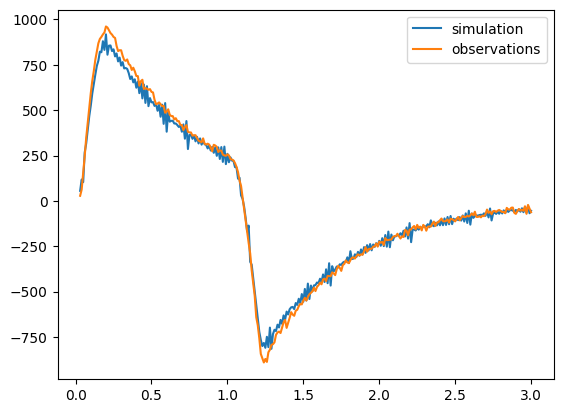

In [ ]:
print(np.exp(X[0,0:3])/500,np.exp(X[0,3:5]),np.exp(X[0,5])*50)
print(Imp(obs,X[0,:],me=me,md=md))

idxToIgnore = 3
t = np.array(t)
simulation = np.array(lung(model,states,X[0,:],t1))
observations = np.array(obs)

mpl.plot(t[idxToIgnore:],simulation[idxToIgnore:], label = 'simulation')
#mpl.plot(np.array(t),np.array(lung(mean)), label = 'mean of initial random samples')
mpl.plot(t[idxToIgnore:],observations[idxToIgnore:], label = 'observations')
mpl.legend()
mpl.show()